This notebook contains the necessary scripts for making the transform model.

In [11]:
'''Starting with the upload of the necessary libraries including 
the smogn (https://github.com/nickkunz/smogn/tree/master):'''
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress
from scipy.special import boxcox1p
import seaborn as sns
import warnings
import smogn
warnings.filterwarnings('ignore')

In [12]:
### either CPU or GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
### Reading the dummy data
raw_data = pd.read_csv('data/all_data_dummy.csv')

In [16]:
### Applying the SMOGN tranformation on the data
target_variables = ['B', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Be',
                    'As', 'Rb', 'Sr', 'Y', 'Mo', 'Cd', 'Sb', 'Cs', 'Ba', 'Pb']
input_features = ['Li', 'Na', 'Ca', 'SO-', 'Cl-', 'Br-', 'Al', 'Si', 'pH', 'F-', 'Fe', 'Mg']
raw_data = raw_data[target_variables+input_features]
all_data = smogn.smoter(
    data = raw_data,  ## pandas dataframe
    y = 'V'  ## string ('header name')
)

r_index: 100%|########################################################################| 12/12 [00:00<00:00, 143.06it/s]


In [17]:
### Performing different transformations on some the parameters
all_data['Cu'], _ = scipy.stats.yeojohnson(all_data['Cu'])
all_data['pH'], _ = scipy.stats.boxcox(all_data['pH']-4)
all_data['V'], _ = scipy.stats.yeojohnson(all_data['V'])
all_data['Ni'], _ = scipy.stats.boxcox(all_data['Ni']+1.01)
all_data['Cs'], _ = scipy.stats.yeojohnson(all_data['Cs']-12)
all_data['Rb'] = np.sqrt(all_data['Rb'])
all_data['Y'], _ = scipy.stats.yeojohnson(all_data['Y'])
all_data['B'], _ = scipy.stats.yeojohnson(all_data['B']-29)
all_data['Pb'], _ = scipy.stats.yeojohnson(all_data['Pb'])
all_data['SO-'], _ = scipy.stats.yeojohnson(all_data['SO-']-100)
all_data['Fe'], _ = scipy.stats.yeojohnson(all_data['Fe'])

In [19]:
def pytorch_NN(all_data, input_features, target_variables, weight_decay=1e-4, patience=50):
    '''
    This function reads the data and based on the interest of the user, different 
    input features and target variables can be selected from the existing measured
    parameters.
    weight_decay is a regularization technique used to prevent overfitting by penalizing 
    large weights in the model. More details at 
    https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    patience refers to the number of training epochs to wait after the last improvement 
    in the monitored metric (e.g., validation loss, accuracy) before stopping the training process.
    More details at https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
    '''
    ### The next block of code prepares the data
    X = all_data[input_features].to_numpy()
    y = all_data[target_variables].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler_x = RobustScaler()
    scaler_y = RobustScaler()
    X_train_norm = scaler_x.fit_transform(X_train)
    X_test_norm = scaler_x.transform(X_test)
    y_train_norm = scaler_y.fit_transform(y_train)
    y_test_norm = scaler_y.transform(y_test)
    XX = torch.from_numpy(X_train_norm.astype(np.float32)).to(device)
    yy = torch.from_numpy(y_train_norm.astype(np.float32)).to(device)
    n_samples, n_features = XX.shape
    input_size = n_features
    output_size = yy.shape[1]
    
    class NN(nn.Module):
        def __init__(self):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(n_features, 86)  # Input layer to hidden layer
            self.norm1 = nn.BatchNorm1d(86) # Batch normalization
            self.fc2 = nn.Linear(86, 32)  # Hidden layer to hidden layer
            self.norm2 = nn.BatchNorm1d(32) # Batch normalization
            self.fc3 = nn.Linear(32, 32)  # Hidden layer to hidden layer
            self.norm3 = nn.BatchNorm1d(32) # Batch normalization
            self.fc4 = nn.Linear(32, output_size)   # Hidden layer to output layer

        def forward(self, x):
            x = torch.relu(self.fc1(x)) # applying relu activation
            x = self.norm1(x) # applying the batch normalization
            x = torch.relu(self.fc2(x))
            x = self.norm2(x)
            x = torch.relu(self.fc3(x))
            x = self.norm3(x)
            x = self.fc4(x)
            return x

    model = NN().to(device) # contruction of the model

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

    # Training loop with early stopping
    num_epochs = 2000
    best_loss = float('inf')
    patience_counter = 0
    loss_values = []
    loss_train = []
    for epoch in range(num_epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(XX)
            loss = criterion(outputs, yy)
            loss.backward()
            loss_train.append(loss.item())
            return loss

        # Perform optimization step
        optimizer.step(closure)

        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.from_numpy(X_test_norm.astype(np.float32)).to(device))
            val_loss = criterion(val_outputs, torch.from_numpy(y_test_norm.astype(np.float32)).to(device))

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience: # looking for the improve of the loss
            print(f'Early stopping at epoch {epoch+1}')
            break

        if (epoch+1) % 100 == 0: # printg out each 100th epoch
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        loss_values.append(val_loss.item())

    print("Training complete.")
    # using the trained model to predict for the test data
    predicted = model(torch.from_numpy(X_test_norm.astype(np.float32)).to(device)).detach().cpu().numpy()
    predicted_original_scale = scaler_y.inverse_transform(predicted)
    y_test_original_scale = scaler_y.inverse_transform(y_test_norm)
    
    # using the trained model to predict for the train data    
    predicted_tr = model(torch.from_numpy(X_train_norm.astype(np.float32)).to(device)).detach().cpu().numpy()
    predicted_original_scale_tr = scaler_y.inverse_transform(predicted_tr)
    y_train_original_scale = scaler_y.inverse_transform(y_train_norm)

    r_values = [] # collects the r value between the measured test and predicted test cases
    for i in range(len(target_variables)):
        slope, intercept, r_value, p_value, std_err = linregress(y_test_original_scale[:, i], predicted_original_scale[:, i])
        r_values.append(r_value)
    
    return r_values, y_test_original_scale, predicted_original_scale, y_train_original_scale, predicted_original_scale_tr, loss_train, loss_values

In [6]:
target_variables = ['B', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Be',
                    'As', 'Rb', 'Sr', 'Y', 'Mo', 'Cd', 'Sb', 'Cs', 'Ba', 'Pb'] # to be predicted
input_features = ['Li', 'Na', 'Ca', 'SO-', 'Cl-', 'Br-', 'Al', 'Si', 'pH', 'F-', 'Fe', 'Mg']
import time
start = time.time()
results = []
for i in range(1000):
    print(f'Starting Round {i}')
    r_values, test_y, predicted_y, train_y, predicted_y_train, l_tr, l_te = pytorch_NN(all_data, input_features, target_variables)
    results.append({
        'r_values': r_values,
        'test_y': test_y,
        'predicted_y': predicted_y,
        'train_y': train_y,
        'predicted_y_train': predicted_y_train,
        'l_tr': l_tr,
        'l_te': l_te,
    })
end = time.time()
print(f'{(end - start)/60} mins')

Starting Round 0
Epoch [100/2000], Loss: 0.1245, Val Loss: 0.1245
Epoch [200/2000], Loss: 0.1171, Val Loss: 0.1171
Early stopping at epoch 226
Training complete.
Starting Round 1
Epoch [100/2000], Loss: 0.1065, Val Loss: 0.1065
Epoch [200/2000], Loss: 0.0932, Val Loss: 0.0932
Early stopping at epoch 208
Training complete.
Starting Round 2
Epoch [100/2000], Loss: 0.1721, Val Loss: 0.1721
Epoch [200/2000], Loss: 0.1509, Val Loss: 0.1509
Early stopping at epoch 260
Training complete.
Starting Round 3
Epoch [100/2000], Loss: 0.1399, Val Loss: 0.1399
Epoch [200/2000], Loss: 0.1078, Val Loss: 0.1078
Epoch [300/2000], Loss: 0.1001, Val Loss: 0.1001
Early stopping at epoch 362
Training complete.
Starting Round 4
Epoch [100/2000], Loss: 0.1750, Val Loss: 0.1750
Epoch [200/2000], Loss: 0.1719, Val Loss: 0.1719
Early stopping at epoch 220
Training complete.
Starting Round 5
Epoch [100/2000], Loss: 0.1233, Val Loss: 0.1233
Epoch [200/2000], Loss: 0.1137, Val Loss: 0.1137
Epoch [300/2000], Loss: 0.

Epoch [200/2000], Loss: 0.0995, Val Loss: 0.0995
Epoch [300/2000], Loss: 0.0967, Val Loss: 0.0967
Early stopping at epoch 324
Training complete.
Starting Round 40
Epoch [100/2000], Loss: 0.1319, Val Loss: 0.1319
Epoch [200/2000], Loss: 0.1159, Val Loss: 0.1159
Early stopping at epoch 228
Training complete.
Starting Round 41
Epoch [100/2000], Loss: 0.1598, Val Loss: 0.1598
Epoch [200/2000], Loss: 0.1487, Val Loss: 0.1487
Epoch [300/2000], Loss: 0.1371, Val Loss: 0.1371
Early stopping at epoch 389
Training complete.
Starting Round 42
Epoch [100/2000], Loss: 0.1149, Val Loss: 0.1149
Epoch [200/2000], Loss: 0.1067, Val Loss: 0.1067
Early stopping at epoch 278
Training complete.
Starting Round 43
Epoch [100/2000], Loss: 0.1430, Val Loss: 0.1430
Epoch [200/2000], Loss: 0.1377, Val Loss: 0.1377
Early stopping at epoch 221
Training complete.
Starting Round 44
Epoch [100/2000], Loss: 0.1416, Val Loss: 0.1416
Epoch [200/2000], Loss: 0.1318, Val Loss: 0.1318
Early stopping at epoch 275
Training c

Epoch [100/2000], Loss: 0.1575, Val Loss: 0.1575
Epoch [200/2000], Loss: 0.1458, Val Loss: 0.1458
Epoch [300/2000], Loss: 0.1474, Val Loss: 0.1474
Early stopping at epoch 320
Training complete.
Starting Round 81
Epoch [100/2000], Loss: 0.2271, Val Loss: 0.2271
Epoch [200/2000], Loss: 0.2183, Val Loss: 0.2183
Early stopping at epoch 208
Training complete.
Starting Round 82
Epoch [100/2000], Loss: 0.1533, Val Loss: 0.1533
Epoch [200/2000], Loss: 0.1411, Val Loss: 0.1411
Epoch [300/2000], Loss: 0.1317, Val Loss: 0.1317
Epoch [400/2000], Loss: 0.1285, Val Loss: 0.1285
Early stopping at epoch 484
Training complete.
Starting Round 83
Epoch [100/2000], Loss: 0.1407, Val Loss: 0.1407
Epoch [200/2000], Loss: 0.1392, Val Loss: 0.1392
Early stopping at epoch 255
Training complete.
Starting Round 84
Epoch [100/2000], Loss: 0.1670, Val Loss: 0.1670
Early stopping at epoch 174
Training complete.
Starting Round 85
Epoch [100/2000], Loss: 0.1264, Val Loss: 0.1264
Epoch [200/2000], Loss: 0.1119, Val Lo

Epoch [200/2000], Loss: 0.1837, Val Loss: 0.1837
Early stopping at epoch 229
Training complete.
Starting Round 122
Epoch [100/2000], Loss: 0.1708, Val Loss: 0.1708
Epoch [200/2000], Loss: 0.1539, Val Loss: 0.1539
Epoch [300/2000], Loss: 0.1434, Val Loss: 0.1434
Epoch [400/2000], Loss: 0.1375, Val Loss: 0.1375
Early stopping at epoch 433
Training complete.
Starting Round 123
Epoch [100/2000], Loss: 0.1415, Val Loss: 0.1415
Early stopping at epoch 162
Training complete.
Starting Round 124
Epoch [100/2000], Loss: 0.1506, Val Loss: 0.1506
Epoch [200/2000], Loss: 0.1455, Val Loss: 0.1455
Epoch [300/2000], Loss: 0.1307, Val Loss: 0.1307
Epoch [400/2000], Loss: 0.1185, Val Loss: 0.1185
Early stopping at epoch 405
Training complete.
Starting Round 125
Epoch [100/2000], Loss: 0.1308, Val Loss: 0.1308
Epoch [200/2000], Loss: 0.1073, Val Loss: 0.1073
Early stopping at epoch 279
Training complete.
Starting Round 126
Epoch [100/2000], Loss: 0.1310, Val Loss: 0.1310
Early stopping at epoch 184
Train

Epoch [200/2000], Loss: 0.1238, Val Loss: 0.1238
Epoch [300/2000], Loss: 0.1165, Val Loss: 0.1165
Epoch [400/2000], Loss: 0.1128, Val Loss: 0.1128
Early stopping at epoch 401
Training complete.
Starting Round 169
Epoch [100/2000], Loss: 0.1425, Val Loss: 0.1425
Epoch [200/2000], Loss: 0.1226, Val Loss: 0.1226
Early stopping at epoch 294
Training complete.
Starting Round 170
Epoch [100/2000], Loss: 0.1407, Val Loss: 0.1407
Epoch [200/2000], Loss: 0.1173, Val Loss: 0.1173
Epoch [300/2000], Loss: 0.1127, Val Loss: 0.1127
Early stopping at epoch 307
Training complete.
Starting Round 171
Epoch [100/2000], Loss: 0.1395, Val Loss: 0.1395
Early stopping at epoch 177
Training complete.
Starting Round 172
Epoch [100/2000], Loss: 0.1605, Val Loss: 0.1605
Early stopping at epoch 198
Training complete.
Starting Round 173
Epoch [100/2000], Loss: 0.1249, Val Loss: 0.1249
Epoch [200/2000], Loss: 0.1086, Val Loss: 0.1086
Early stopping at epoch 262
Training complete.
Starting Round 174
Epoch [100/2000]

Epoch [300/2000], Loss: 0.0898, Val Loss: 0.0898
Epoch [400/2000], Loss: 0.0862, Val Loss: 0.0862
Early stopping at epoch 417
Training complete.
Starting Round 208
Epoch [100/2000], Loss: 0.1320, Val Loss: 0.1320
Epoch [200/2000], Loss: 0.1123, Val Loss: 0.1123
Early stopping at epoch 292
Training complete.
Starting Round 209
Epoch [100/2000], Loss: 0.1395, Val Loss: 0.1395
Early stopping at epoch 190
Training complete.
Starting Round 210
Epoch [100/2000], Loss: 0.1113, Val Loss: 0.1113
Epoch [200/2000], Loss: 0.1003, Val Loss: 0.1003
Early stopping at epoch 213
Training complete.
Starting Round 211
Epoch [100/2000], Loss: 0.1532, Val Loss: 0.1532
Epoch [200/2000], Loss: 0.1310, Val Loss: 0.1310
Early stopping at epoch 284
Training complete.
Starting Round 212
Epoch [100/2000], Loss: 0.1284, Val Loss: 0.1284
Epoch [200/2000], Loss: 0.1217, Val Loss: 0.1217
Early stopping at epoch 210
Training complete.
Starting Round 213
Epoch [100/2000], Loss: 0.0957, Val Loss: 0.0957
Epoch [200/2000]

Epoch [100/2000], Loss: 0.1491, Val Loss: 0.1491
Early stopping at epoch 160
Training complete.
Starting Round 253
Epoch [100/2000], Loss: 0.1354, Val Loss: 0.1354
Epoch [200/2000], Loss: 0.1251, Val Loss: 0.1251
Epoch [300/2000], Loss: 0.1128, Val Loss: 0.1128
Epoch [400/2000], Loss: 0.1134, Val Loss: 0.1134
Epoch [500/2000], Loss: 0.1041, Val Loss: 0.1041
Early stopping at epoch 567
Training complete.
Starting Round 254
Epoch [100/2000], Loss: 0.1386, Val Loss: 0.1386
Epoch [200/2000], Loss: 0.1264, Val Loss: 0.1264
Epoch [300/2000], Loss: 0.1137, Val Loss: 0.1137
Epoch [400/2000], Loss: 0.1072, Val Loss: 0.1072
Epoch [500/2000], Loss: 0.1026, Val Loss: 0.1026
Early stopping at epoch 553
Training complete.
Starting Round 255
Epoch [100/2000], Loss: 0.1047, Val Loss: 0.1047
Epoch [200/2000], Loss: 0.0954, Val Loss: 0.0954
Epoch [300/2000], Loss: 0.0890, Val Loss: 0.0890
Early stopping at epoch 346
Training complete.
Starting Round 256
Epoch [100/2000], Loss: 0.1678, Val Loss: 0.1678
E

Epoch [200/2000], Loss: 0.1009, Val Loss: 0.1009
Early stopping at epoch 260
Training complete.
Starting Round 294
Epoch [100/2000], Loss: 0.1237, Val Loss: 0.1237
Epoch [200/2000], Loss: 0.0962, Val Loss: 0.0962
Epoch [300/2000], Loss: 0.0930, Val Loss: 0.0930
Early stopping at epoch 333
Training complete.
Starting Round 295
Epoch [100/2000], Loss: 0.1226, Val Loss: 0.1226
Early stopping at epoch 173
Training complete.
Starting Round 296
Epoch [100/2000], Loss: 0.1266, Val Loss: 0.1266
Epoch [200/2000], Loss: 0.1133, Val Loss: 0.1133
Early stopping at epoch 201
Training complete.
Starting Round 297
Epoch [100/2000], Loss: 0.1292, Val Loss: 0.1292
Epoch [200/2000], Loss: 0.1131, Val Loss: 0.1131
Epoch [300/2000], Loss: 0.1101, Val Loss: 0.1101
Early stopping at epoch 377
Training complete.
Starting Round 298
Epoch [100/2000], Loss: 0.1687, Val Loss: 0.1687
Epoch [200/2000], Loss: 0.1428, Val Loss: 0.1428
Epoch [300/2000], Loss: 0.1370, Val Loss: 0.1370
Epoch [400/2000], Loss: 0.1310, V

Epoch [100/2000], Loss: 0.1595, Val Loss: 0.1595
Epoch [200/2000], Loss: 0.1435, Val Loss: 0.1435
Early stopping at epoch 272
Training complete.
Starting Round 335
Epoch [100/2000], Loss: 0.1405, Val Loss: 0.1405
Epoch [200/2000], Loss: 0.1195, Val Loss: 0.1195
Epoch [300/2000], Loss: 0.1097, Val Loss: 0.1097
Epoch [400/2000], Loss: 0.1058, Val Loss: 0.1058
Early stopping at epoch 498
Training complete.
Starting Round 336
Epoch [100/2000], Loss: 0.1753, Val Loss: 0.1753
Early stopping at epoch 158
Training complete.
Starting Round 337
Epoch [100/2000], Loss: 0.1253, Val Loss: 0.1253
Epoch [200/2000], Loss: 0.1120, Val Loss: 0.1120
Early stopping at epoch 213
Training complete.
Starting Round 338
Epoch [100/2000], Loss: 0.1401, Val Loss: 0.1401
Early stopping at epoch 196
Training complete.
Starting Round 339
Epoch [100/2000], Loss: 0.1236, Val Loss: 0.1236
Early stopping at epoch 139
Training complete.
Starting Round 340
Epoch [100/2000], Loss: 0.2166, Val Loss: 0.2166
Epoch [200/2000]

Epoch [200/2000], Loss: 0.1609, Val Loss: 0.1609
Early stopping at epoch 204
Training complete.
Starting Round 377
Epoch [100/2000], Loss: 0.1179, Val Loss: 0.1179
Epoch [200/2000], Loss: 0.1115, Val Loss: 0.1115
Early stopping at epoch 216
Training complete.
Starting Round 378
Epoch [100/2000], Loss: 0.1524, Val Loss: 0.1524
Early stopping at epoch 182
Training complete.
Starting Round 379
Epoch [100/2000], Loss: 0.1490, Val Loss: 0.1490
Epoch [200/2000], Loss: 0.1315, Val Loss: 0.1315
Epoch [300/2000], Loss: 0.1168, Val Loss: 0.1168
Early stopping at epoch 385
Training complete.
Starting Round 380
Epoch [100/2000], Loss: 0.1292, Val Loss: 0.1292
Epoch [200/2000], Loss: 0.1129, Val Loss: 0.1129
Early stopping at epoch 256
Training complete.
Starting Round 381
Epoch [100/2000], Loss: 0.1324, Val Loss: 0.1324
Epoch [200/2000], Loss: 0.1231, Val Loss: 0.1231
Early stopping at epoch 226
Training complete.
Starting Round 382
Epoch [100/2000], Loss: 0.1339, Val Loss: 0.1339
Epoch [200/2000]

Epoch [200/2000], Loss: 0.1223, Val Loss: 0.1223
Epoch [300/2000], Loss: 0.1109, Val Loss: 0.1109
Epoch [400/2000], Loss: 0.1070, Val Loss: 0.1070
Early stopping at epoch 422
Training complete.
Starting Round 420
Epoch [100/2000], Loss: 0.1283, Val Loss: 0.1283
Epoch [200/2000], Loss: 0.1182, Val Loss: 0.1182
Epoch [300/2000], Loss: 0.1096, Val Loss: 0.1096
Early stopping at epoch 381
Training complete.
Starting Round 421
Epoch [100/2000], Loss: 0.1825, Val Loss: 0.1825
Epoch [200/2000], Loss: 0.1660, Val Loss: 0.1660
Early stopping at epoch 270
Training complete.
Starting Round 422
Epoch [100/2000], Loss: 0.1426, Val Loss: 0.1426
Epoch [200/2000], Loss: 0.1164, Val Loss: 0.1164
Epoch [300/2000], Loss: 0.1038, Val Loss: 0.1038
Epoch [400/2000], Loss: 0.1040, Val Loss: 0.1040
Early stopping at epoch 444
Training complete.
Starting Round 423
Epoch [100/2000], Loss: 0.1389, Val Loss: 0.1389
Epoch [200/2000], Loss: 0.1166, Val Loss: 0.1166
Epoch [300/2000], Loss: 0.1127, Val Loss: 0.1127
E

Epoch [100/2000], Loss: 0.1321, Val Loss: 0.1321
Early stopping at epoch 190
Training complete.
Starting Round 463
Epoch [100/2000], Loss: 0.1392, Val Loss: 0.1392
Epoch [200/2000], Loss: 0.1227, Val Loss: 0.1227
Epoch [300/2000], Loss: 0.1208, Val Loss: 0.1208
Early stopping at epoch 392
Training complete.
Starting Round 464
Epoch [100/2000], Loss: 0.1214, Val Loss: 0.1214
Epoch [200/2000], Loss: 0.1014, Val Loss: 0.1014
Epoch [300/2000], Loss: 0.0907, Val Loss: 0.0907
Epoch [400/2000], Loss: 0.0855, Val Loss: 0.0855
Early stopping at epoch 422
Training complete.
Starting Round 465
Epoch [100/2000], Loss: 0.1622, Val Loss: 0.1622
Epoch [200/2000], Loss: 0.1443, Val Loss: 0.1443
Epoch [300/2000], Loss: 0.1408, Val Loss: 0.1408
Early stopping at epoch 315
Training complete.
Starting Round 466
Epoch [100/2000], Loss: 0.1598, Val Loss: 0.1598
Epoch [200/2000], Loss: 0.1516, Val Loss: 0.1516
Epoch [300/2000], Loss: 0.1423, Val Loss: 0.1423
Epoch [400/2000], Loss: 0.1328, Val Loss: 0.1328
E

Epoch [100/2000], Loss: 0.1259, Val Loss: 0.1259
Epoch [200/2000], Loss: 0.1088, Val Loss: 0.1088
Epoch [300/2000], Loss: 0.1070, Val Loss: 0.1070
Epoch [400/2000], Loss: 0.0985, Val Loss: 0.0985
Early stopping at epoch 435
Training complete.
Starting Round 506
Epoch [100/2000], Loss: 0.1225, Val Loss: 0.1225
Epoch [200/2000], Loss: 0.1173, Val Loss: 0.1173
Early stopping at epoch 258
Training complete.
Starting Round 507
Epoch [100/2000], Loss: 0.1289, Val Loss: 0.1289
Epoch [200/2000], Loss: 0.1104, Val Loss: 0.1104
Early stopping at epoch 298
Training complete.
Starting Round 508
Epoch [100/2000], Loss: 0.1696, Val Loss: 0.1696
Epoch [200/2000], Loss: 0.1616, Val Loss: 0.1616
Epoch [300/2000], Loss: 0.1577, Val Loss: 0.1577
Epoch [400/2000], Loss: 0.1453, Val Loss: 0.1453
Early stopping at epoch 435
Training complete.
Starting Round 509
Epoch [100/2000], Loss: 0.1439, Val Loss: 0.1439
Epoch [200/2000], Loss: 0.1218, Val Loss: 0.1218
Early stopping at epoch 223
Training complete.
Sta

Epoch [100/2000], Loss: 0.1563, Val Loss: 0.1563
Epoch [200/2000], Loss: 0.1296, Val Loss: 0.1296
Epoch [300/2000], Loss: 0.1218, Val Loss: 0.1218
Early stopping at epoch 340
Training complete.
Starting Round 548
Epoch [100/2000], Loss: 0.1302, Val Loss: 0.1302
Early stopping at epoch 198
Training complete.
Starting Round 549
Epoch [100/2000], Loss: 0.1268, Val Loss: 0.1268
Epoch [200/2000], Loss: 0.1103, Val Loss: 0.1103
Early stopping at epoch 273
Training complete.
Starting Round 550
Epoch [100/2000], Loss: 0.1346, Val Loss: 0.1346
Epoch [200/2000], Loss: 0.1139, Val Loss: 0.1139
Epoch [300/2000], Loss: 0.0942, Val Loss: 0.0942
Epoch [400/2000], Loss: 0.0979, Val Loss: 0.0979
Early stopping at epoch 497
Training complete.
Starting Round 551
Epoch [100/2000], Loss: 0.1149, Val Loss: 0.1149
Epoch [200/2000], Loss: 0.1046, Val Loss: 0.1046
Epoch [300/2000], Loss: 0.0937, Val Loss: 0.0937
Epoch [400/2000], Loss: 0.0882, Val Loss: 0.0882
Early stopping at epoch 429
Training complete.
Sta

Epoch [100/2000], Loss: 0.1260, Val Loss: 0.1260
Epoch [200/2000], Loss: 0.1215, Val Loss: 0.1215
Epoch [300/2000], Loss: 0.1143, Val Loss: 0.1143
Early stopping at epoch 312
Training complete.
Starting Round 588
Epoch [100/2000], Loss: 0.1505, Val Loss: 0.1505
Epoch [200/2000], Loss: 0.1485, Val Loss: 0.1485
Epoch [300/2000], Loss: 0.1373, Val Loss: 0.1373
Early stopping at epoch 390
Training complete.
Starting Round 589
Epoch [100/2000], Loss: 0.1231, Val Loss: 0.1231
Epoch [200/2000], Loss: 0.1072, Val Loss: 0.1072
Epoch [300/2000], Loss: 0.1034, Val Loss: 0.1034
Early stopping at epoch 307
Training complete.
Starting Round 590
Epoch [100/2000], Loss: 0.1081, Val Loss: 0.1081
Early stopping at epoch 187
Training complete.
Starting Round 591
Epoch [100/2000], Loss: 0.1266, Val Loss: 0.1266
Early stopping at epoch 199
Training complete.
Starting Round 592
Epoch [100/2000], Loss: 0.1468, Val Loss: 0.1468
Epoch [200/2000], Loss: 0.1357, Val Loss: 0.1357
Epoch [300/2000], Loss: 0.1184, V

Epoch [100/2000], Loss: 0.1310, Val Loss: 0.1310
Epoch [200/2000], Loss: 0.1212, Val Loss: 0.1212
Epoch [300/2000], Loss: 0.1134, Val Loss: 0.1134
Epoch [400/2000], Loss: 0.1093, Val Loss: 0.1093
Epoch [500/2000], Loss: 0.1033, Val Loss: 0.1033
Early stopping at epoch 583
Training complete.
Starting Round 629
Epoch [100/2000], Loss: 0.1511, Val Loss: 0.1511
Epoch [200/2000], Loss: 0.1333, Val Loss: 0.1333
Epoch [300/2000], Loss: 0.1280, Val Loss: 0.1280
Epoch [400/2000], Loss: 0.1268, Val Loss: 0.1268
Epoch [500/2000], Loss: 0.1240, Val Loss: 0.1240
Early stopping at epoch 507
Training complete.
Starting Round 630
Epoch [100/2000], Loss: 0.1328, Val Loss: 0.1328
Epoch [200/2000], Loss: 0.1242, Val Loss: 0.1242
Epoch [300/2000], Loss: 0.1227, Val Loss: 0.1227
Early stopping at epoch 398
Training complete.
Starting Round 631
Epoch [100/2000], Loss: 0.1007, Val Loss: 0.1007
Epoch [200/2000], Loss: 0.0849, Val Loss: 0.0849
Epoch [300/2000], Loss: 0.0814, Val Loss: 0.0814
Epoch [400/2000], 

Epoch [600/2000], Loss: 0.1067, Val Loss: 0.1067
Epoch [700/2000], Loss: 0.1020, Val Loss: 0.1020
Early stopping at epoch 763
Training complete.
Starting Round 664
Epoch [100/2000], Loss: 0.1270, Val Loss: 0.1270
Epoch [200/2000], Loss: 0.1142, Val Loss: 0.1142
Epoch [300/2000], Loss: 0.1014, Val Loss: 0.1014
Epoch [400/2000], Loss: 0.0954, Val Loss: 0.0954
Epoch [500/2000], Loss: 0.0957, Val Loss: 0.0957
Early stopping at epoch 502
Training complete.
Starting Round 665
Epoch [100/2000], Loss: 0.1387, Val Loss: 0.1387
Epoch [200/2000], Loss: 0.1218, Val Loss: 0.1218
Early stopping at epoch 280
Training complete.
Starting Round 666
Epoch [100/2000], Loss: 0.1285, Val Loss: 0.1285
Epoch [200/2000], Loss: 0.1129, Val Loss: 0.1129
Early stopping at epoch 300
Training complete.
Starting Round 667
Epoch [100/2000], Loss: 0.1836, Val Loss: 0.1836
Epoch [200/2000], Loss: 0.1579, Val Loss: 0.1579
Epoch [300/2000], Loss: 0.1484, Val Loss: 0.1484
Epoch [400/2000], Loss: 0.1456, Val Loss: 0.1456
E

Epoch [200/2000], Loss: 0.1254, Val Loss: 0.1254
Epoch [300/2000], Loss: 0.1248, Val Loss: 0.1248
Early stopping at epoch 301
Training complete.
Starting Round 708
Epoch [100/2000], Loss: 0.1328, Val Loss: 0.1328
Epoch [200/2000], Loss: 0.1276, Val Loss: 0.1276
Epoch [300/2000], Loss: 0.1185, Val Loss: 0.1185
Early stopping at epoch 352
Training complete.
Starting Round 709
Epoch [100/2000], Loss: 0.1490, Val Loss: 0.1490
Early stopping at epoch 149
Training complete.
Starting Round 710
Epoch [100/2000], Loss: 0.1425, Val Loss: 0.1425
Epoch [200/2000], Loss: 0.1326, Val Loss: 0.1326
Epoch [300/2000], Loss: 0.1256, Val Loss: 0.1256
Epoch [400/2000], Loss: 0.1191, Val Loss: 0.1191
Epoch [500/2000], Loss: 0.1141, Val Loss: 0.1141
Early stopping at epoch 511
Training complete.
Starting Round 711
Epoch [100/2000], Loss: 0.1614, Val Loss: 0.1614
Epoch [200/2000], Loss: 0.1583, Val Loss: 0.1583
Early stopping at epoch 213
Training complete.
Starting Round 712
Epoch [100/2000], Loss: 0.1631, V

Early stopping at epoch 676
Training complete.
Starting Round 752
Epoch [100/2000], Loss: 0.1268, Val Loss: 0.1268
Epoch [200/2000], Loss: 0.1169, Val Loss: 0.1169
Early stopping at epoch 287
Training complete.
Starting Round 753
Epoch [100/2000], Loss: 0.1804, Val Loss: 0.1804
Epoch [200/2000], Loss: 0.1742, Val Loss: 0.1742
Epoch [300/2000], Loss: 0.1679, Val Loss: 0.1679
Early stopping at epoch 362
Training complete.
Starting Round 754
Epoch [100/2000], Loss: 0.1177, Val Loss: 0.1177
Epoch [200/2000], Loss: 0.0972, Val Loss: 0.0972
Epoch [300/2000], Loss: 0.0881, Val Loss: 0.0881
Epoch [400/2000], Loss: 0.0844, Val Loss: 0.0844
Epoch [500/2000], Loss: 0.0842, Val Loss: 0.0842
Epoch [600/2000], Loss: 0.0721, Val Loss: 0.0721
Early stopping at epoch 683
Training complete.
Starting Round 755
Epoch [100/2000], Loss: 0.1175, Val Loss: 0.1175
Epoch [200/2000], Loss: 0.1024, Val Loss: 0.1024
Early stopping at epoch 295
Training complete.
Starting Round 756
Epoch [100/2000], Loss: 0.1204, V

Epoch [200/2000], Loss: 0.1497, Val Loss: 0.1497
Early stopping at epoch 256
Training complete.
Starting Round 791
Epoch [100/2000], Loss: 0.1213, Val Loss: 0.1213
Epoch [200/2000], Loss: 0.1052, Val Loss: 0.1052
Epoch [300/2000], Loss: 0.0980, Val Loss: 0.0980
Epoch [400/2000], Loss: 0.0968, Val Loss: 0.0968
Early stopping at epoch 442
Training complete.
Starting Round 792
Epoch [100/2000], Loss: 0.1413, Val Loss: 0.1413
Epoch [200/2000], Loss: 0.1129, Val Loss: 0.1129
Epoch [300/2000], Loss: 0.1077, Val Loss: 0.1077
Epoch [400/2000], Loss: 0.1033, Val Loss: 0.1033
Early stopping at epoch 413
Training complete.
Starting Round 793
Epoch [100/2000], Loss: 0.1132, Val Loss: 0.1132
Epoch [200/2000], Loss: 0.1007, Val Loss: 0.1007
Epoch [300/2000], Loss: 0.0971, Val Loss: 0.0971
Epoch [400/2000], Loss: 0.0895, Val Loss: 0.0895
Early stopping at epoch 424
Training complete.
Starting Round 794
Epoch [100/2000], Loss: 0.1811, Val Loss: 0.1811
Epoch [200/2000], Loss: 0.1720, Val Loss: 0.1720
E

Epoch [100/2000], Loss: 0.1510, Val Loss: 0.1510
Epoch [200/2000], Loss: 0.1376, Val Loss: 0.1376
Early stopping at epoch 232
Training complete.
Starting Round 829
Epoch [100/2000], Loss: 0.1462, Val Loss: 0.1462
Early stopping at epoch 187
Training complete.
Starting Round 830
Epoch [100/2000], Loss: 0.1733, Val Loss: 0.1733
Epoch [200/2000], Loss: 0.1583, Val Loss: 0.1583
Epoch [300/2000], Loss: 0.1558, Val Loss: 0.1558
Early stopping at epoch 381
Training complete.
Starting Round 831
Epoch [100/2000], Loss: 0.1189, Val Loss: 0.1189
Epoch [200/2000], Loss: 0.1110, Val Loss: 0.1110
Early stopping at epoch 230
Training complete.
Starting Round 832
Epoch [100/2000], Loss: 0.1227, Val Loss: 0.1227
Epoch [200/2000], Loss: 0.1119, Val Loss: 0.1119
Epoch [300/2000], Loss: 0.1036, Val Loss: 0.1036
Epoch [400/2000], Loss: 0.0993, Val Loss: 0.0993
Early stopping at epoch 452
Training complete.
Starting Round 833
Epoch [100/2000], Loss: 0.1436, Val Loss: 0.1436
Epoch [200/2000], Loss: 0.1328, V

Epoch [200/2000], Loss: 0.1673, Val Loss: 0.1673
Epoch [300/2000], Loss: 0.1653, Val Loss: 0.1653
Early stopping at epoch 395
Training complete.
Starting Round 870
Epoch [100/2000], Loss: 0.1845, Val Loss: 0.1845
Epoch [200/2000], Loss: 0.1746, Val Loss: 0.1746
Epoch [300/2000], Loss: 0.1683, Val Loss: 0.1683
Early stopping at epoch 384
Training complete.
Starting Round 871
Epoch [100/2000], Loss: 0.0913, Val Loss: 0.0913
Epoch [200/2000], Loss: 0.0787, Val Loss: 0.0787
Early stopping at epoch 236
Training complete.
Starting Round 872
Epoch [100/2000], Loss: 0.1253, Val Loss: 0.1253
Epoch [200/2000], Loss: 0.1154, Val Loss: 0.1154
Epoch [300/2000], Loss: 0.1048, Val Loss: 0.1048
Early stopping at epoch 312
Training complete.
Starting Round 873
Epoch [100/2000], Loss: 0.1240, Val Loss: 0.1240
Epoch [200/2000], Loss: 0.1099, Val Loss: 0.1099
Early stopping at epoch 228
Training complete.
Starting Round 874
Epoch [100/2000], Loss: 0.1452, Val Loss: 0.1452
Early stopping at epoch 150
Train

Epoch [100/2000], Loss: 0.1491, Val Loss: 0.1491
Epoch [200/2000], Loss: 0.1368, Val Loss: 0.1368
Epoch [300/2000], Loss: 0.1323, Val Loss: 0.1323
Early stopping at epoch 397
Training complete.
Starting Round 912
Epoch [100/2000], Loss: 0.1713, Val Loss: 0.1713
Early stopping at epoch 151
Training complete.
Starting Round 913
Epoch [100/2000], Loss: 0.1550, Val Loss: 0.1550
Epoch [200/2000], Loss: 0.1463, Val Loss: 0.1463
Early stopping at epoch 286
Training complete.
Starting Round 914
Epoch [100/2000], Loss: 0.1278, Val Loss: 0.1278
Epoch [200/2000], Loss: 0.1138, Val Loss: 0.1138
Epoch [300/2000], Loss: 0.1091, Val Loss: 0.1091
Early stopping at epoch 385
Training complete.
Starting Round 915
Epoch [100/2000], Loss: 0.1126, Val Loss: 0.1126
Epoch [200/2000], Loss: 0.1032, Val Loss: 0.1032
Epoch [300/2000], Loss: 0.1009, Val Loss: 0.1009
Early stopping at epoch 313
Training complete.
Starting Round 916
Epoch [100/2000], Loss: 0.1642, Val Loss: 0.1642
Epoch [200/2000], Loss: 0.1537, V

Epoch [100/2000], Loss: 0.1476, Val Loss: 0.1476
Epoch [200/2000], Loss: 0.1213, Val Loss: 0.1213
Epoch [300/2000], Loss: 0.1141, Val Loss: 0.1141
Epoch [400/2000], Loss: 0.1184, Val Loss: 0.1184
Early stopping at epoch 409
Training complete.
Starting Round 956
Epoch [100/2000], Loss: 0.1523, Val Loss: 0.1523
Epoch [200/2000], Loss: 0.1412, Val Loss: 0.1412
Epoch [300/2000], Loss: 0.1280, Val Loss: 0.1280
Epoch [400/2000], Loss: 0.1250, Val Loss: 0.1250
Epoch [500/2000], Loss: 0.1239, Val Loss: 0.1239
Epoch [600/2000], Loss: 0.1178, Val Loss: 0.1178
Epoch [700/2000], Loss: 0.1108, Val Loss: 0.1108
Epoch [800/2000], Loss: 0.1053, Val Loss: 0.1053
Early stopping at epoch 897
Training complete.
Starting Round 957
Epoch [100/2000], Loss: 0.1614, Val Loss: 0.1614
Early stopping at epoch 192
Training complete.
Starting Round 958
Epoch [100/2000], Loss: 0.1451, Val Loss: 0.1451
Epoch [200/2000], Loss: 0.1345, Val Loss: 0.1345
Early stopping at epoch 274
Training complete.
Starting Round 959
E

Epoch [100/2000], Loss: 0.1540, Val Loss: 0.1540
Epoch [200/2000], Loss: 0.1390, Val Loss: 0.1390
Early stopping at epoch 228
Training complete.
Starting Round 998
Epoch [100/2000], Loss: 0.1575, Val Loss: 0.1575
Early stopping at epoch 133
Training complete.
Starting Round 999
Epoch [100/2000], Loss: 0.1742, Val Loss: 0.1742
Epoch [200/2000], Loss: 0.1630, Val Loss: 0.1630
Early stopping at epoch 259
Training complete.
881.3774025440216 Seconds
14.689623375733694 mins


In [7]:
### Separating the R2 score of each model
r_squared_values = [[r**2 for r in result['r_values']] for result in results]
df = pd.DataFrame(r_squared_values, columns=target_variables)
df_melted = df.melt(var_name='Element', value_name='R_squared')

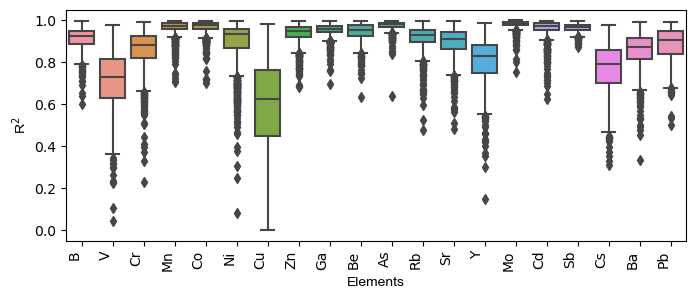

In [8]:
### Making a plot to have a view on the R2 score for each predicted element
fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.boxplot(data=df_melted, x='Element', y='R_squared')
plt.xlabel('Elements', fontname = "Arial", fontsize=10)
plt.ylabel('R$^2$', fontname = "Arial", fontsize=10)
plt.xticks(rotation=90, ha='right')
plt.show()